# SDR Based Antenna / Filter Analyzer

This is version 1.0 of the Antenna Analyzer. It is quite slow as it tunes to a centre frequency, takes a sample and moves up the sweep 1MHz at a time. A 300MHz to 1.4GHz sweep take about 125 seconds. Look for the version 2.0 notebook instead.

### Source: https://git.scriptforge.org/arden/sdr-antenna-analyzer

The aim of this notebook is to provide some sample code for connecting to an SDR using GNURadio blocks in Python instead of using the GNURadio Companion. This way we can save the data collected from a flow graph and analyze it with other tools such as Bokeh graphing library. It has also been a great way to learn some of the lower level functions of GNURadio and how flow graphs work.

We connect the items like this:

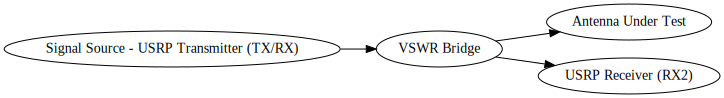

In [1]:
# Use the graphviz library to make a nice node graph
from graphviz import Digraph
hw_setup = Digraph(comment='Hardware Setup')
hw_setup.attr(rankdir='LR')
hw_setup.node('A', 'Signal Source - USRP Transmitter (TX/RX)')
hw_setup.node('B', 'VSWR Bridge')
hw_setup.node('D', 'Antenna Under Test')
hw_setup.node('C', 'USRP Receiver (RX2)')
hw_setup.edges(['AB', 'BD', 'BC'])
hw_setup

In [2]:
# Import GNURadio blocks to create our app
from gnuradio import gr
from gnuradio import blocks
from gnuradio import analog
from gnuradio import uhd
from gnuradio import fft

In [3]:
from datetime import datetime
import numpy
import time
import pandas
import scipy
from scipy import signal
import ipywidgets as widgets
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [4]:
# Set some variables for start
sample_rate = 1e6
freq = 400e6
input_gain_db = 30
noise_gain_db = 30
fft_size = 256

In [5]:
# Set up the receiver
receiver = uhd.usrp_source(",".join(("", "")), 
                        uhd.stream_args(cpu_format="fc32",channels=range(1)))
receiver.set_gain(input_gain_db, 0)
receiver.set_antenna('RX2', 0)
receiver.set_samp_rate(sample_rate)
receiver.set_center_freq(freq)

<gnuradio.uhd.uhd_swig.tune_result_t; proxy of <Swig Object of type 'uhd::tune_result_t *' at 0x7f3f39e36a80> >

In [6]:
# Set up the Transmitter
transmitter = uhd.usrp_sink(",".join(("", "")), uhd.stream_args(cpu_format="fc32",	channels=range(1),),)
transmitter.set_samp_rate(sample_rate)
transmitter.set_gain(noise_gain_db, 0)
transmitter.set_antenna('TX/RX', 0)
transmitter.set_center_freq(freq)

<gnuradio.uhd.uhd_swig.tune_result_t; proxy of <Swig Object of type 'uhd::tune_result_t *' at 0x7f3f2cadd600> >

### Flowgraph

These are the equivalent of the graphical flow graphs that GNURadio Companion makes. In fact when you 'run' a GRC flowgraph it generates Python code similar to below to 'connect' the inputs and outputs of each block.

In [7]:
# Create a flow graph with all the bits to send the signal source as well as receive it
# Signal is just a sine wave in this case as we are only sampling the centre frequency
flowgraph = gr.top_block()

sig_source = analog.sig_source_c(sample_rate, analog.GR_SIN_WAVE, 1000, 1, 0)
s2v = blocks.stream_to_vector(gr.sizeof_gr_complex*1, fft_size)
fft_vec = fft.fft_vcc(fft_size, True, (), True, 1)
cm2 = blocks.complex_to_mag_squared(fft_size)
probe_loss = blocks.probe_signal_vf(fft_size)

flowgraph.connect((sig_source, 0), (transmitter, 0))
flowgraph.connect((receiver, 0), (s2v, 0))
flowgraph.connect((s2v, 0), (fft_vec, 0))
flowgraph.connect((fft_vec, 0), (cm2, 0))
flowgraph.connect((cm2, 0), (probe_loss, 0))
flowgraph.start()
calibration_df = None
return_signal = None

In [8]:
def get_signal_loss(start_freq, stop_freq, step_freq=sample_rate, step_time=0.1, nbwidgets=None):
    '''
    Run through the frequency range and collect the levels
    '''
    freq = start_freq
    start_time = datetime.now()
    nbwidgets['status'].value = "Starting sweep from %.3fMHz to %.3fMHz in steps of %.0fMHz" % (start_freq/1e6, 
                                                                          stop_freq/1e6, 
                                                                          step_freq/1e6)
    df_return = pandas.DataFrame(columns=['Return Signal'])
    nbwidgets['progress'].value = 0
    while freq < stop_freq:
        transmitter.set_center_freq(freq)
        receiver.set_center_freq(freq)
        time.sleep(step_time)
        fft_vector = probe_loss.level()
        ctr_freq_level = fft_vector[fft_size/2]
        return_df = pandas.DataFrame([ctr_freq_level], index=[freq/1e6], columns=['Return Signal'])
        df_return = df_return.append(return_df)
        nbwidgets['progress'].value = int(((freq - start_freq)/(stop_freq-start_freq))*100)
        freq += step_freq
    end_time = datetime.now()
    nbwidgets['progress'].value = 100
    nbwidgets['status'].value = "Finished in %d seconds" % (end_time - start_time).seconds
    return df_return

In [9]:
def show_return_plot(df, out):
    '''
    Takes a Pandas DF with the return signal from the sweep and puts it in a graph
    '''
    dfsource = ColumnDataSource(df)

    return_plot = figure(title="Return Signal (Reflected)",
                         width=900,
                         x_axis_label='Frequency', 
                         y_axis_label='Level',
                         y_axis_type='log')
    return_plot.circle(x='index', y='Return Signal', source=dfsource, color='red')
    return_plot.line(x='index', y='Smoothed Return', source=dfsource, color='blue', line_width=3)
    with out:
        show(return_plot)

In [10]:
def apply_calibration(df):
    if calibration_df is not None:
        df['Smoothed Return'] = df['Smoothed Return'].subtract(calibration_df['Smoothed Calibration'])
        df['Return Signal'] = df['Return Signal'].subtract(calibration_df['Smoothed Calibration'])
        the_min = df['Smoothed Return'].min()
        if the_min < 0:
            df['Smoothed Return'] = df['Smoothed Return'].add(abs(the_min))
            df['Return Signal'] = df['Return Signal'].add(abs(the_min))
    return df

In [11]:
# Set up the widgets to control the scan
def start_scan(b):
    ''' Respond to button click event '''
    try:
        global return_signal
        fr = nbw['freq_range'].value
        fstart = fr[0] * 1e6
        fstop = fr[1] * 1e6
        fs = nbw['freq_step'].value * 1e6
        st = nbw['sample_time'].value
        return_signal = get_signal_loss(fstart, fstop, step_freq=fs, step_time=st, nbwidgets=nbw)
        return_signal['Smoothed Return'] = signal.savgol_filter(return_signal['Return Signal'], 53, 3)
        if calibration_df is not None:
            return_signal = apply_calibration(return_signal)
        show_return_plot(return_signal, nbw['out'])
    except Exception as err:
        with out:
            print(type(err))
            print(err)

def reset_calibration(b):
    nbw['status'].value = 'Calibration dataframe cleared'
    global calibration_df
    calibration_df = None
            
def start_calibration(b):
    ''' Respond to button click event '''
    try:
        global calibration_df
        fr = nbw['freq_range'].value
        fstart = fr[0] * 1e6
        fstop = fr[1] * 1e6
        fs = nbw['freq_step'].value * 1e6
        st = nbw['sample_time'].value
        calibration_df = get_signal_loss(fstart, fstop, step_freq=fs, step_time=st, nbwidgets=nbw)
        calibration_df['Smoothed Calibration'] = signal.savgol_filter(calibration_df['Return Signal'], 53, 3)
        nbw['status'].value = 'Calibration finished'
    except Exception as err:
        with out:
            print(err)
            
nbw = {}
out = nbw['out'] = widgets.Output()
nbw['progress'] = widgets.FloatProgress(min=0, max=100, value=0)
nbw['freq_range']= widgets.IntRangeSlider(min=70, max=3000, value=[300, 1400], step=1)
nbw['freq_step'] = widgets.BoundedIntText(value=1, min=1, max=10, step=1)
nbw['sample_time'] = widgets.BoundedFloatText(value=0.1, min=0, max=1.5, step=0.1)
nbw['status'] = widgets.HTML(value="Waiting to scan")
nbw['start_scan'] = widgets.Button(description='Start Scan', button_style='info')
nbw['start_scan'].on_click(start_scan)
nbw['start_cal'] = widgets.Button(description='Start Calibration', button_style='')
nbw['start_cal'].on_click(start_calibration)
nbw['reset_cal'] = widgets.Button(description='Clear Calibration', button_style='')
nbw['reset_cal'].on_click(reset_calibration)
display(widgets.VBox([
    widgets.HBox([widgets.Label('Scan Progress', layout={'min_width': '150px'}), nbw['progress']]),
    widgets.HBox([widgets.Label('Status', layout={'min_width': '150px'}), nbw['status']]),
    widgets.HBox([widgets.Label('Frequency Range', layout={'min_width': '150px'}), nbw['freq_range']]),
    widgets.HBox([widgets.Label('Frequency Step', layout={'min_width': '150px'}), nbw['freq_step']]),
    widgets.HBox([widgets.Label('Sample Time', layout={'min_width': '150px'}), nbw['sample_time']]),
    widgets.HBox([nbw['start_scan'], nbw['start_cal'], nbw['reset_cal']]),
    nbw['out']]))

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oTGFiZWwodmFsdWU9dSdTY2FuIFByb2dyZXNzJywgbGF5b3V0PUxheW91dChtaW5fd2lkdGg9dScxNTBweCcpKSwgRmxvYXRQcm9ncmVzcyjigKY=
